<a href="https://colab.research.google.com/github/caroheymes/jedha_final_project/blob/master/model_with_semantic_and_tech_attributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
os.chdir('/content/drive/MyDrive/111_goldfinger/data_modeling')

In [ ]:
!pip install lightgbm
!pip install catboost

In [ ]:
!pip install matplotlib==3.4
!pip install sklearn
!pip install missingpy
!pip install xgboost

In [123]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") # to avoid deprecation warnings
import sys


#Graph libraries

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
%matplotlib inline


#Preprocessing libraries

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#Model Selection
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from missingpy import KNNImputer

In [125]:
#Loading dataset
df = pd.read_csv('/content/drive/MyDrive/111_goldfinger/data_modeling/tech.csv')

In [126]:
df.sample()

,Unnamed: 0,content_len,title_len_char,h1_len,nb_h2,nb_h3,nb_links,has_canonical,is_top_ten,content_score,title_score,technologies,majestic,mjrank,a_rank,ref_sn,ref_ip,spend
112097,112097,757,37,1,41,0,48,1,0,0.0,0.0,384.0,5212.0,5522.0,13580.0,8809.0,15669.0,888.0


In [127]:
df = df.drop(columns=['Unnamed: 0'])

In [128]:
df.sample()

,content_len,title_len_char,h1_len,nb_h2,nb_h3,nb_links,has_canonical,is_top_ten,content_score,title_score,technologies,majestic,mjrank,a_rank,ref_sn,ref_ip,spend
115084,43308,48,6,203,4,45,0,1,0.727061,71.428571,79.0,178887.0,181547.0,75638.0,986.0,1237.0,3284.0


# Distribution plot

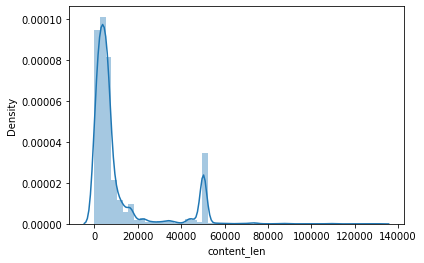

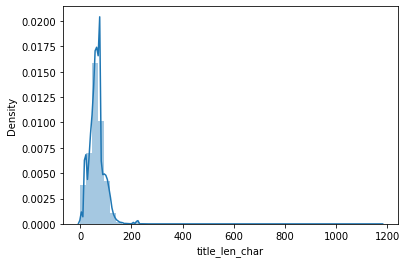

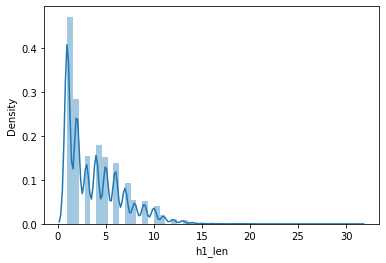

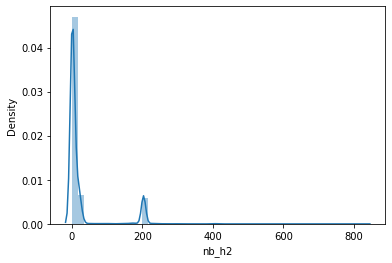

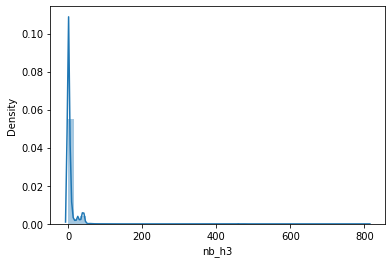

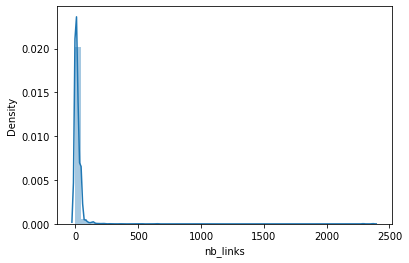

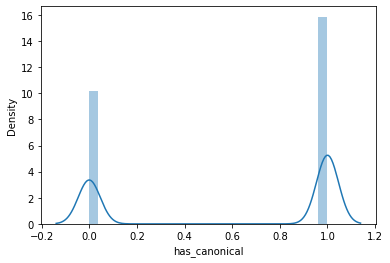

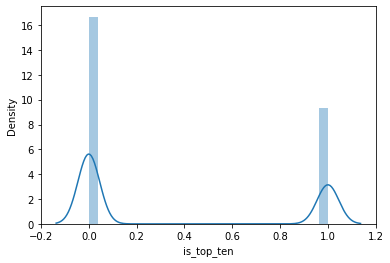

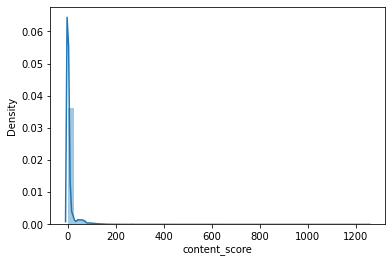

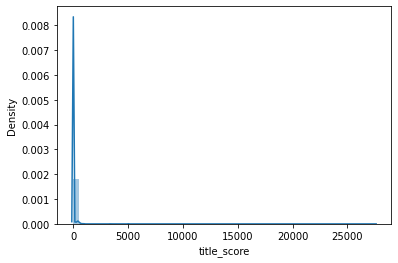

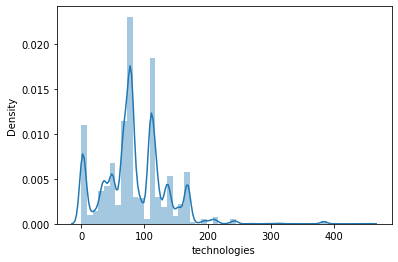

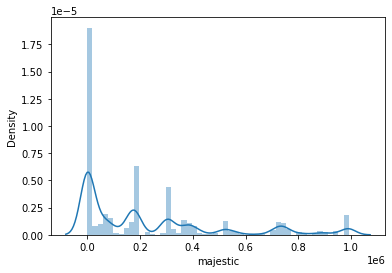

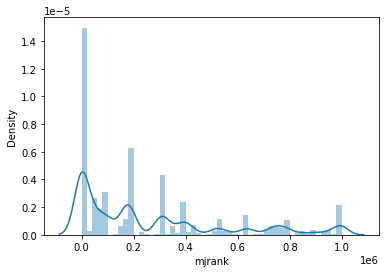

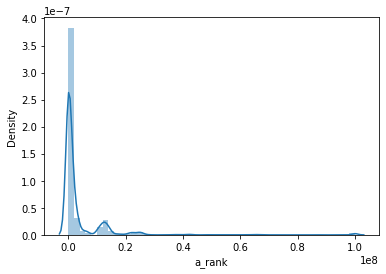

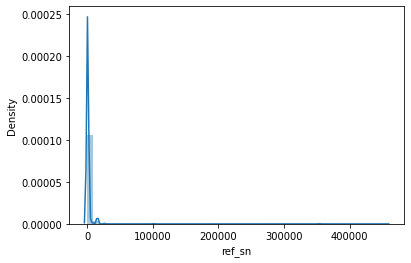

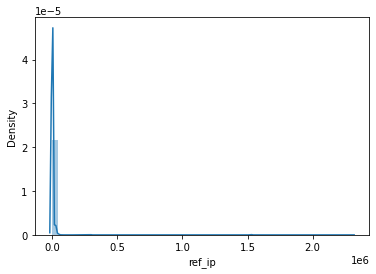

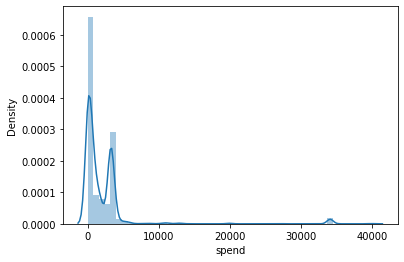

In [7]:
plt.rcParams['figure.figsize'] = [6, 2]
%matplotlib inline

# sample time series data
df2 = df.copy()


# create distplots
for c in df2.columns:
    plt.figure()             # <==================== here!
    sns.distplot(df2[c])

# Plot pairwise relationships in the dataset


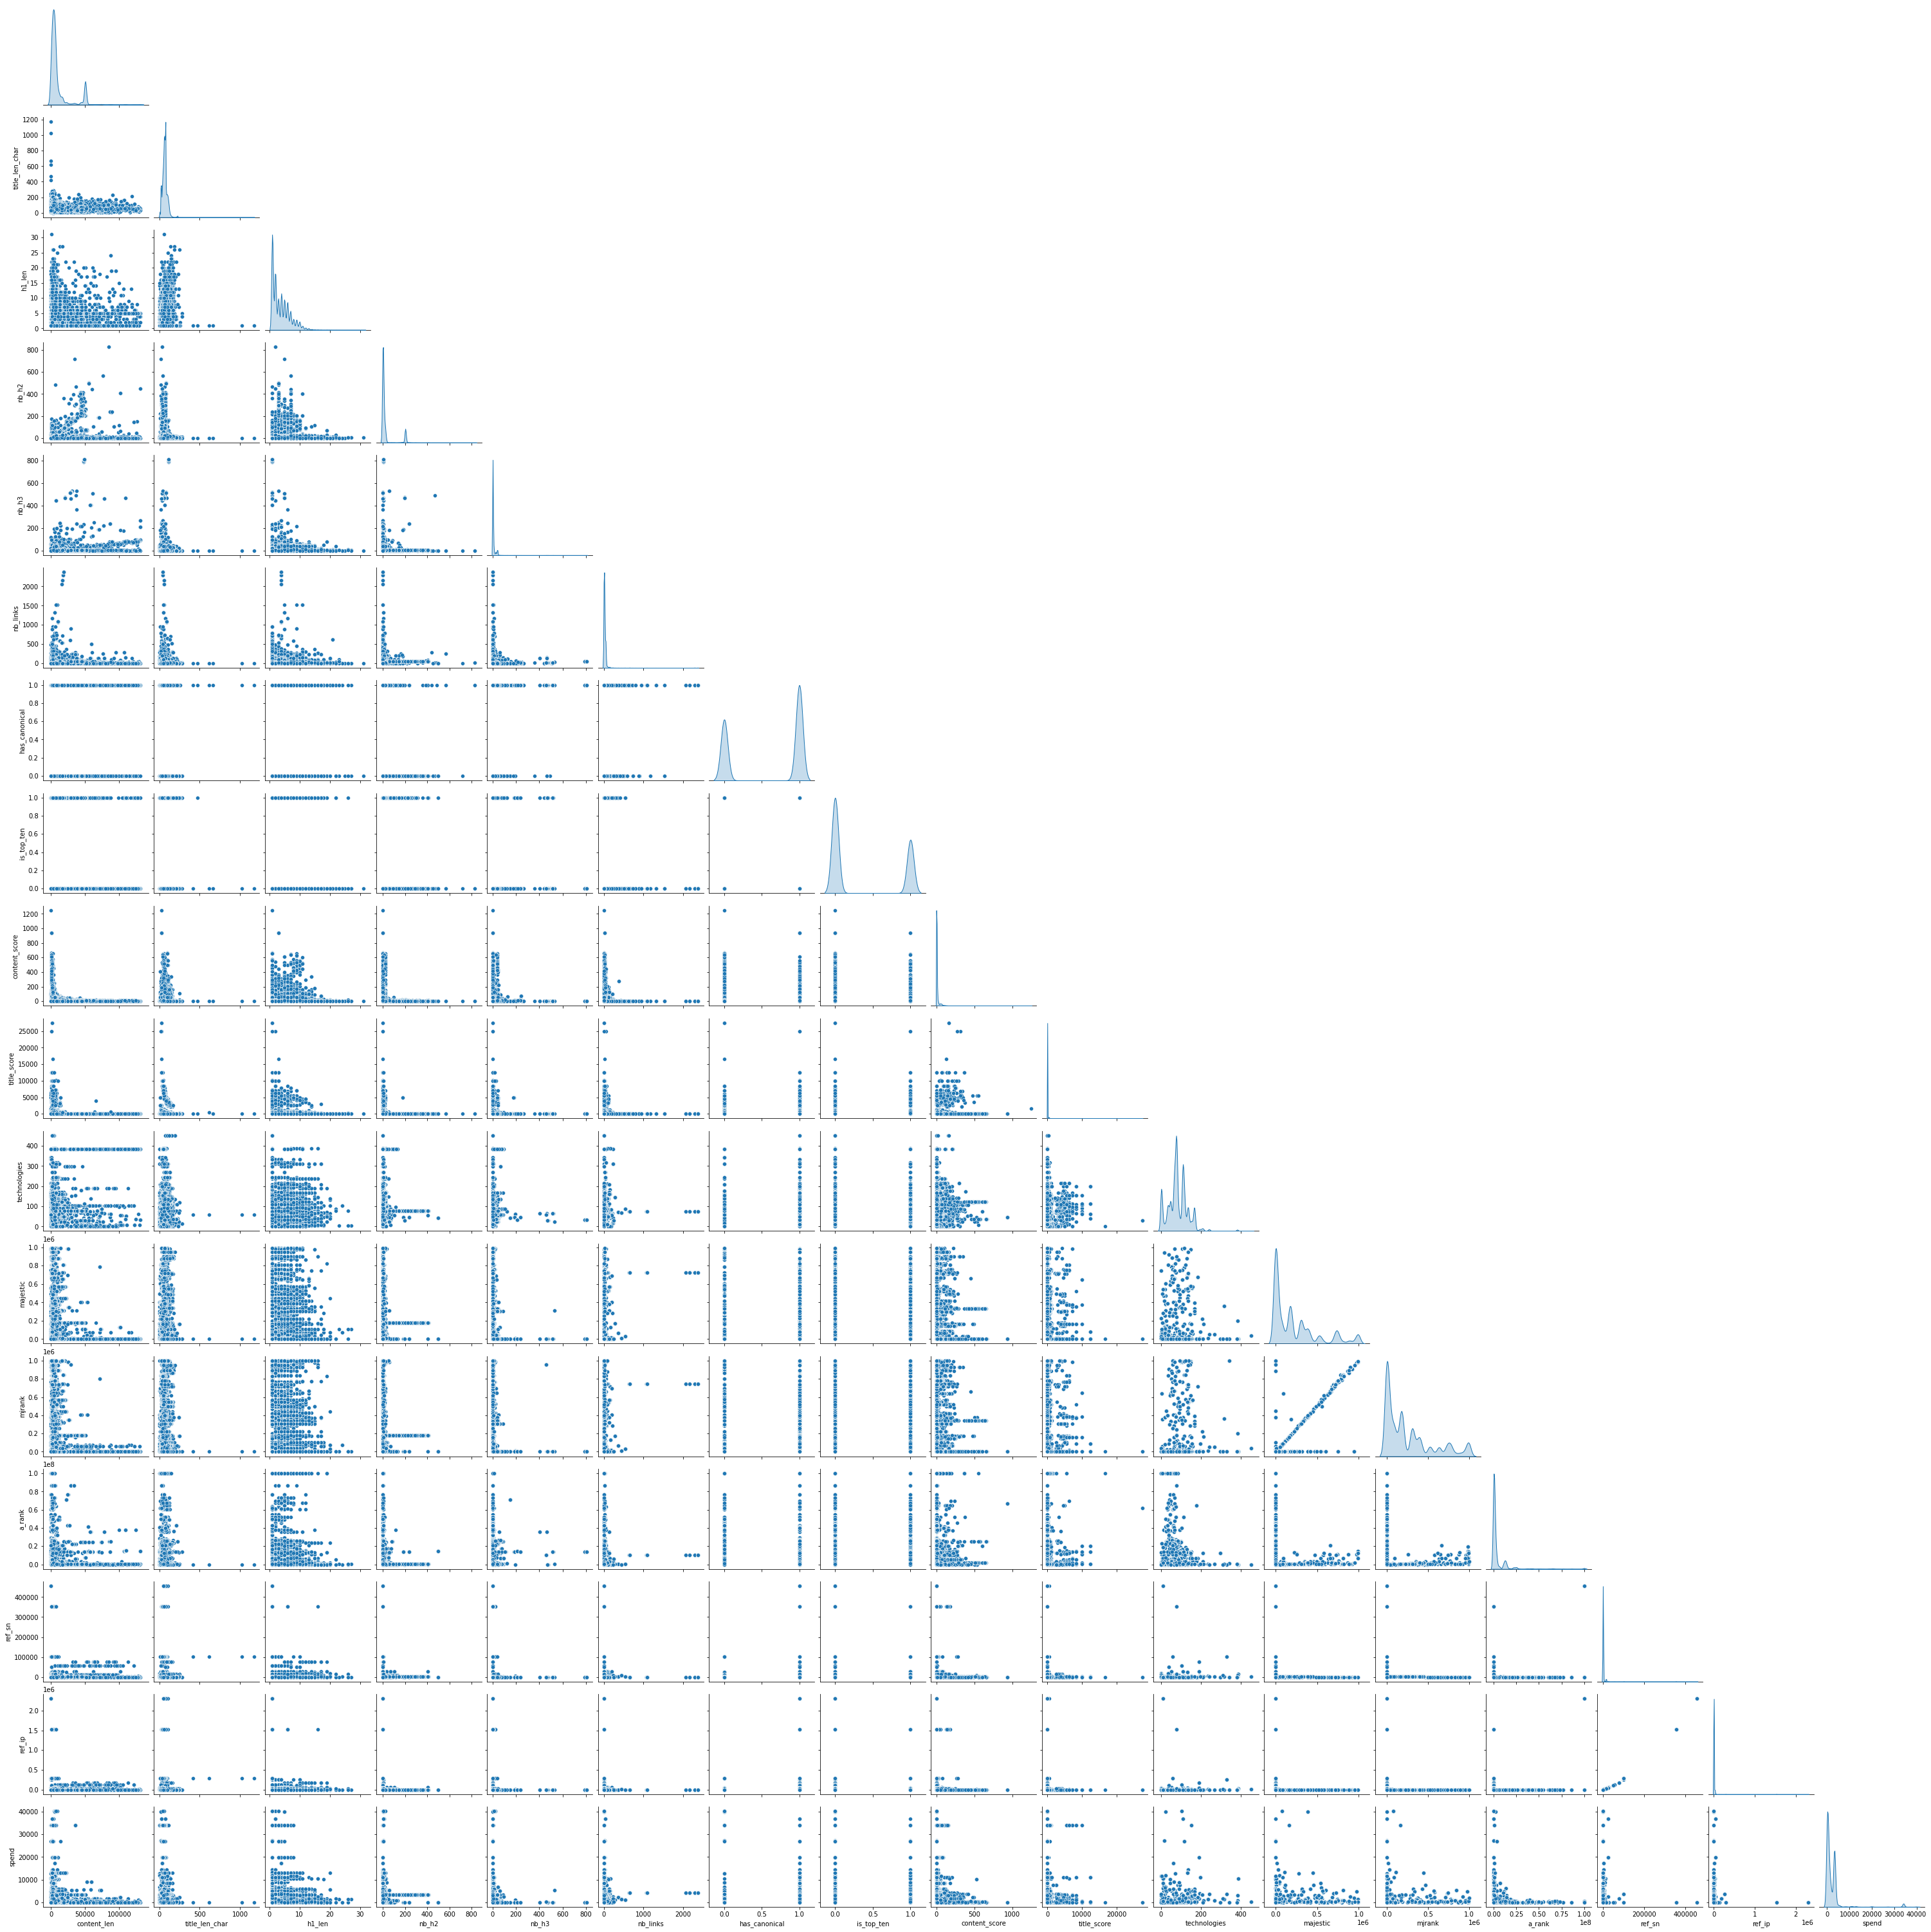

In [8]:
sns.pairplot(df,corner=True, diag_kind="kde");

# **Part II Preprocessing & model selection**

## Detection of highly correlated features

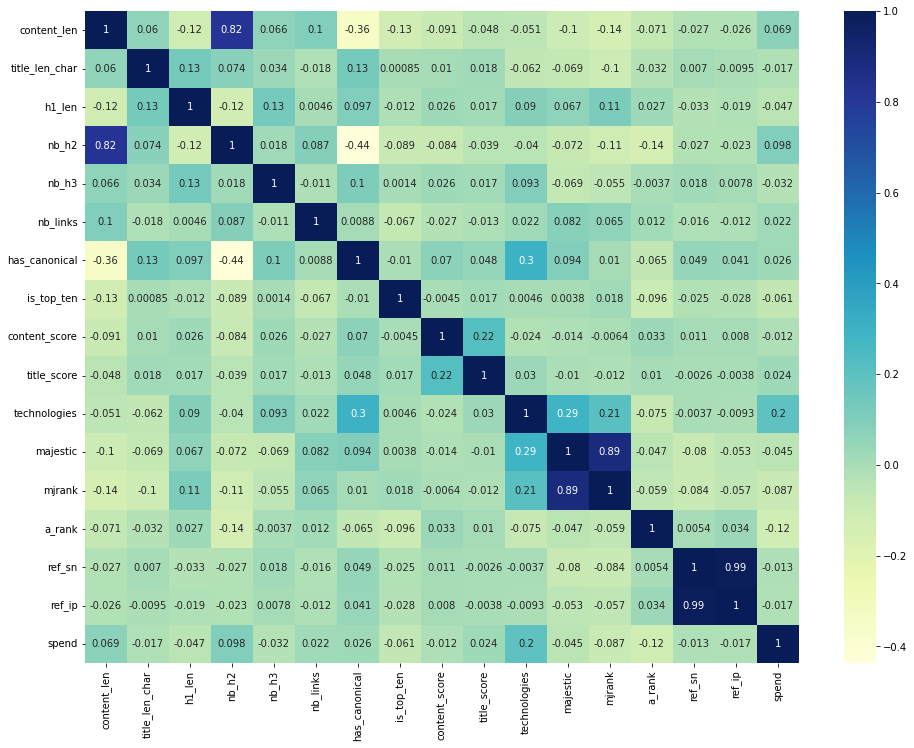

In [129]:
# Plotting a matrix correlation of features
corr = df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap='YlGnBu');

In [130]:
#Let's identify most correlated features :
correlations = corr.unstack().reset_index()
correlations = correlations.rename(columns=dict(zip(correlations.columns, ['feature1', 'feature2', 'coeff'])))
correlations['coeff'] = correlations['coeff'].apply(lambda x : abs(x))

#Filtering features with a high correlation : 
top_correlations = correlations[(correlations.coeff !=1) &  (correlations.coeff > 0.8)].drop_duplicates(subset=['coeff'])
top_correlations

,feature1,feature2,coeff
3,content_len,nb_h2,0.816141
199,majestic,mjrank,0.885486
253,ref_sn,ref_ip,0.985849


In [131]:
to_delete = top_correlations.feature2.values
to_delete

array(['nb_h2', 'mjrank', 'ref_ip'], dtype=object)

In [132]:
#Conclusion : let's drop the features which appear to be to much correlated with others !
df.drop(columns=to_delete, inplace=True)

# Pipelines

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130693 entries, 0 to 130692
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   content_len     130693 non-null  int64  
 1   title_len_char  130693 non-null  int64  
 2   h1_len          130693 non-null  int64  
 3   nb_h3           130693 non-null  int64  
 4   nb_links        130693 non-null  int64  
 5   has_canonical   130693 non-null  int64  
 6   is_top_ten      130693 non-null  int64  
 7   content_score   130693 non-null  float64
 8   title_score     130693 non-null  float64
 9   technologies    121577 non-null  float64
 10  majestic        121577 non-null  float64
 11  a_rank          121577 non-null  float64
 12  ref_sn          121577 non-null  float64
 13  spend           121577 non-null  float64
dtypes: float64(7), int64(7)
memory usage: 14.0 MB


In [134]:
# Missing values
nan_features = pd.Series(100* df.isnull().sum().sort_values(ascending=False) / df.shape[0]).to_frame()
nan_features.rename(columns={0:'nan_percent'}, inplace=True)
nan_features[nan_features.nan_percent > 0]

,nan_percent
spend,6.975125
ref_sn,6.975125
a_rank,6.975125
majestic,6.975125
technologies,6.975125


In [135]:
df.shape

(130693, 14)

In [136]:
nan_features[nan_features.nan_percent > 0].index

Index(['spend', 'ref_sn', 'a_rank', 'majestic', 'technologies'], dtype='object')

In [137]:
#delete records with nan values
df = df.dropna(subset=nan_features[nan_features.nan_percent > 0].index)

In [138]:
df.shape

(121577, 14)

Different tests have been done on the selection of features to set-up the best model. 
Finally, we discard from the analysis the tech spent and the majestic rank (based on top 1M of websites wordwide which cannot substitute the 'Authority Score').
One of the improvement paths in the future could indeed be to test the integration of external data (ahref, semrush).


In [47]:
df = df[['content_len', 'title_len_char', 'h1_len', 'nb_h3', 'nb_links',
       'has_canonical', 'is_top_ten', 'content_score', 'title_score',
      'ref_sn']]

Splitting features & target

In [141]:
target = 'is_top_ten'

X = df.loc[:, df.columns != target]
Y = df.loc[:,target] 

Y = Y.apply(lambda x: float(x[1:]) if type(x)==str else x)

#Split the data into a train set and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Numpy conversion to arrays Done !")

Convert pandas DataFrames to numpy arrays...
...Numpy conversion to arrays Done !


In [142]:
# Automatically detect positions of numeric/categorical features :
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['content_len', 'title_len_char', 'h1_len', 'nb_h3', 'nb_links', 'has_canonical', 'content_score', 'title_score', 'technologies', 'majestic', 'a_rank', 'ref_sn', 'spend']  at positions  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Found categorical features  []  at positions  []


In [143]:
from missingpy import KNNImputer
imputer = KNNImputer()

numeric_transformer = Pipeline(steps=[
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()) 
])
#StandardScaler()
# Create pipeline for categorical features

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('preprocessings on train set...Done.')


# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('preprocessings on test set...Done.')

Performing preprocessings on train set...
preprocessings on train set...Done.
Performing preprocessings on test set...
preprocessings on test set...Done.


# **PART II : Models fitting**

In [145]:
#Instanciate models

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

gbm = xgb.XGBClassifier()
rf = RandomForestClassifier()
et =  ExtraTreesClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
lgb = lgb.LGBMClassifier()
cb = CatBoostClassifier()




In [146]:
#from sklearn.metrics import classification_report #pas utilisé
classifier = []
for model in [gbm, rf, et,  ada, gb, lr, dt,lgb, cb]:
  

  model.fit(X_train, Y_train)
  Y_train_pred    = model.predict(X_train)
  Y_test_pred     = model.predict(X_test)
  score           = model.score(X_test, Y_test)
  

#for classification only

  accuracy_train  = accuracy_score(Y_train, Y_train_pred)
  accuracy_test   = accuracy_score(Y_test, Y_test_pred)
  f1_score_train  = f1_score(Y_train, Y_train_pred)
  f1_score_test   = f1_score(Y_test, Y_test_pred)

  print()
  print('model : ', model, ' - score : ', score, 'accuracy_train : ', accuracy_train, 'accuracy_test : ', accuracy_test)

  

  classifier.append({'classifier'     : model,
                    'score'           : score,
                    'accuracy_train'  : accuracy_train,
                    'accuracy_test'   : accuracy_test,
                    'f1_score_train'  : f1_score_train,
                    'f1_score_test'   : f1_score_test
                     }
                    )


model :  XGBClassifier()  - score :  0.7175933541700937 accuracy_train :  0.7195175866997049 accuracy_test :  0.7175933541700937

model :  RandomForestClassifier()  - score :  0.7202253660141471 accuracy_train :  0.8796331520342172 accuracy_test :  0.7202253660141471

model :  ExtraTreesClassifier()  - score :  0.7202664911992104 accuracy_train :  0.8796331520342172 accuracy_test :  0.7202664911992104

model :  AdaBoostClassifier()  - score :  0.7102730712288206 accuracy_train :  0.7136262222267918 accuracy_test :  0.7102730712288206

model :  GradientBoostingClassifier()  - score :  0.7154959697318638 accuracy_train :  0.7194558970193603 accuracy_test :  0.7154959697318638

model :  LogisticRegression()  - score :  0.6450896529034381 accuracy_train :  0.6464975683984331 accuracy_test :  0.6450896529034381

model :  DecisionTreeClassifier()  - score :  0.6986346438558974 accuracy_train :  0.8796331520342172 accuracy_test :  0.6986346438558974

model :  LGBMClassifier()  - score :  0.7

In [147]:
all_scores = pd.DataFrame.from_dict(classifier)
print(all_scores.sort_values(by='f1_score_test', ascending=False)['classifier'].values[:3])
all_scores.sort_values(by='f1_score_test', ascending=False)

 RandomForestClassifier() ExtraTreesClassifier()]


,classifier,score,accuracy_train,accuracy_test,f1_score_train,f1_score_test
8,<catboost.core.CatBoostClassifier object at 0x...,0.731206,0.753899,0.731206,0.629657,0.596344
1,"(DecisionTreeClassifier(max_features='auto', r...",0.720225,0.879633,0.720225,0.831114,0.595084
2,"(ExtraTreeClassifier(random_state=1942769803),...",0.720266,0.879633,0.720266,0.822063,0.587658
7,LGBMClassifier(),0.727176,0.737983,0.727176,0.598399,0.583239
6,DecisionTreeClassifier(),0.698635,0.879633,0.698635,0.822063,0.559774
0,XGBClassifier(),0.717593,0.719518,0.717593,0.553636,0.550795
4,([DecisionTreeRegressor(criterion='friedman_ms...,0.715496,0.719456,0.715496,0.552468,0.547014
3,"(DecisionTreeClassifier(max_depth=1, random_st...",0.710273,0.713626,0.710273,0.537133,0.532236
5,LogisticRegression(),0.645090,0.646498,0.645090,0.257729,0.256291


In [ ]:
#There is a problem with the DataFrame display.
# We'll consider best model as random forrest

# Is it possible to lower over fitting on best model ?

In [88]:
from sklearn.model_selection import cross_val_score,GridSearchCV

In [96]:
model = RandomForestClassifier()
param_grid = { 
    'n_estimators': [200,250, 300, 500],
    'max_depth' : [15, 20],
    # 'criterion' :['gini', 'entropy'],
}
m2 = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
m2.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [15, 20], 'n_estimators': [300]})

In [97]:
m2.best_params_

{'max_depth': 15, 'n_estimators': 300}

In [104]:
model = RandomForestClassifier(max_depth= 15, 
                               n_estimators= 300)
classifier = []
model.fit(X_train, Y_train)
Y_train_pred    = model.predict(X_train)
Y_test_pred     = model.predict(X_test)
score           = model.score(X_test, Y_test)


#for classification only

accuracy_train  = accuracy_score(Y_train, Y_train_pred)
accuracy_test   = accuracy_score(Y_test, Y_test_pred)
f1_score_train  = f1_score(Y_train, Y_train_pred)
f1_score_test   = f1_score(Y_test, Y_test_pred)

print()
print('model : ', model, ' - score : ', score, 'accuracy_train : ', accuracy_train, 'accuracy_test : ', accuracy_test)



classifier.append({'classifier'     : model,
                    'score'           : score,           
                    'accuracy_test'   : accuracy_test,
                    'f1_score_test'   : f1_score_test
                     }
                    )
pd.DataFrame(data=classifier)


model :  RandomForestClassifier(max_depth=15, n_estimators=300)  - score :  0.7320694193123869 accuracy_train :  0.7872631373315101 accuracy_test :  0.7320694193123869


,classifier,score,accuracy_test,f1_score_test
0,"(DecisionTreeClassifier(max_depth=15, max_feat...",0.732069,0.732069,0.600772


In [116]:
import pandas as pd
feat_importances = pd.Series(model.feature_importances_ ,index=df.loc[:, df.columns != target].columns).to_frame()
feat_importances.rename(columns={0: 'feature_importance'}, inplace=True)
feat_importances.sort_values(by='feature_importance', ascending=False).mul(100)

,feature_importance
content_len,27.354154
title_len_char,20.092430
ref_sn,12.701783
nb_links,11.273156
content_score,9.180662
title_score,7.420889
nb_h3,5.297318
h1_len,4.872949
has_canonical,1.806658


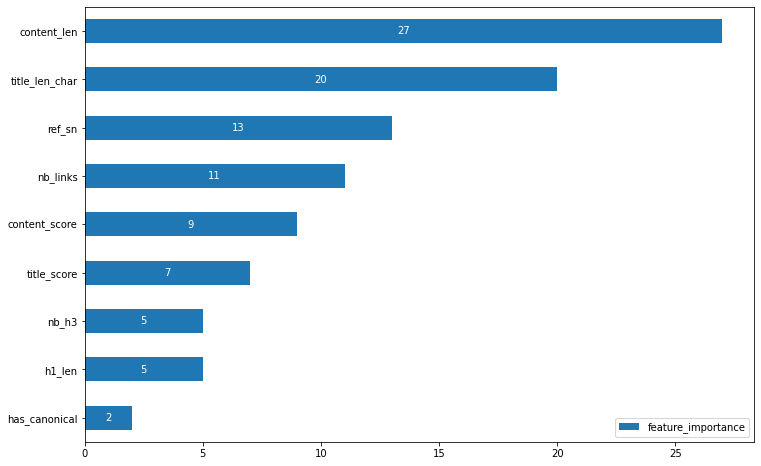

In [121]:
ax = feat_importances.sort_values(by='feature_importance', ascending=True).mul(100).round().plot(kind='barh', figsize=(12,8));
for c in ax.containers:
    ax.bar_label(c, label_type='center', color="white")